## An Improved Stage Progress Chart

...

In [1]:
import notebookimport

In [2]:
sr = __import__("Charts - Stage Results")
ssd = __import__("Charts - Split Sector Delta")

importing Jupyter notebook from Charts - Stage Results.ipynb
importing Jupyter notebook from Charts - Split Sector Delta.ipynb


In [3]:
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline


import sqlite3
dbname='wrc18.db'
conn = sqlite3.connect(dbname)

In [4]:
if __name__=='__main__':
    year=2018
    rc='RC1'
    ss='SS4'
    rally='Sweden'
    snum=int(ss.replace('SS',''))

    #typ='stage_times_stage' #stage_times_stage stage_times_overall
    typ='stage_times_overall'

In [5]:
def samesign(a,b):
    return (a*b) >0

In [6]:
def dbGetStageResult(conn, rally, typ, snum, rc):
    if typ=='stage_times_stage': mstime = 'diffFirstMs'
    elif typ=='stage_times_overall': mstime = 'totalTimeMs'
    q='''
    SELECT st.{mstime}, st.{mstime} AS mstime, st.position, sc.name as class, i.code, i.distance, i.name, CAST(REPLACE(code,'SS','') AS INTEGER) snum,
    sl.`driver.code`, sl.`entrant.name`
    FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
    INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId
    WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" AND snum={stage} ORDER BY snum, st.{mstime}
    '''.format(rc=rc,rally=rally, typ=typ, stage=snum, mstime=mstime)
    return pd.read_sql(q,conn)



In [9]:
if __name__=='__main__':
    rally_stages = sr.dbGetRallyStages(conn, rally)
    stagerank = sr.dbGetStageRank(conn, rally, rc)
    curr = dbGetStageResult(conn, rally, typ, snum, rc)
    curr['snum'] = 'curr'
    prev = dbGetStageResult(conn, rally, typ, snum-1, rc)
    prev['snum'] = 'prev'

    _currprevstagerank = pd.concat([curr,prev]).reset_index(drop=True)

In [10]:
def getCurrPrevStageRank(conn, rally, rc, stage, typ='stage_times_overall'):
    snum = int(stage.replace('SS','')) if isinstance(stage, str) and stage.startswith('SS') else int(stage)
    
    stagerank = sr.dbGetStageRank(conn, rally, rc)
    curr = dbGetStageResult(conn, rally, typ, snum, rc)
    curr['snum'] = 'curr'
    prev = dbGetStageResult(conn, rally, typ, snum-1, rc)
    prev['snum'] = 'prev'

    currprevstagerank = pd.concat([curr,prev]).reset_index(drop=True)
    return currprevstagerank

In [11]:
if __name__=='__main__':
    currprevstagerank = getCurrPrevStageRank(conn, rally, rc, ss)

In [12]:
#want rebased delta if different sign else smaller
#?? if same sign, then return smaller?
'''def thing(overall,delta):
    if overall<0 and delta<0:
        return overall if overall>delta else delta
    elif overall>0 and delta>0:
        return overall if overall<delta else delta
    return delta
    #return min([a,b], key=abs)
'''
#Return thing closest to zero if samesign, else delta
def thing2(overall,delta):
    if samesign(overall,delta): return min([overall,delta], key=abs)
    return delta

In [13]:
def rebaseStageRankProgress(currprevstagerank, drivercode=None):
    if drivercode is None:
        #use the first code - is this risky?
        #Could lead to nonsensical drift from splitdurations if differnt drivercodes used?
        drivercode = currprevstagerank['driver.code'].iloc[0]
        
    dfx = currprevstagerank.pivot('driver.code','snum','totalTimeMs')

    rebase = dfx.loc[drivercode].to_dict()
    #print(rebase)
    dfx['rebased_curr'] = ((dfx['curr'] - rebase['curr'])/1000).astype(float).round(1)
    #On first stage, there is no prev...
    if 'prev' in dfx.columns:
        dfx['rebased_prev'] = ((dfx['prev'] - rebase['prev'])/1000).astype(float).round(1)
    else: dfx['rebased_prev'] = 0
    dfx['rebased_delta'] = dfx['rebased_curr'] - dfx['rebased_prev']

    dfx['deltaxx']=dfx.apply(lambda x: thing2(x['rebased_curr'],x['rebased_delta']), axis=1)
    return dfx

In [14]:
#Narrative is broken in the development of this chart
def stageProgessBar(df,prev,curr,delta,deltaxx,title=None,
                    neg='r',pos='g', lneg='pink',lpos='lightgreen',
                    splitdurations=None, invert_colours=False):
    
    if invert_colours:
        pos,neg=neg,pos
        lpos,lneg=lneg,lpos
        
    #df = df.sort_values(curr,ascending=False)
    fig, ax = plt.subplots(figsize=(15,8))
    ax.yaxis.label.set_visible(False)
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both',length=0)

    plt.axvline(x=0,linestyle='dashed',color='grey')

    
    #The previous colour maps weren't quite correct
    def colmap3(row):
        if not samesign(row[deltaxx], row[curr]): return 'w'
        return lneg if row[curr]<row[prev] else lpos

    def colmap4(row):
        #if not samesign(row[delta], row[deltaxx]): return 'lightgrey'    
        if not samesign(row[curr],row[delta]):
            return lneg if (row[deltaxx]<0) else lpos
        return neg if (row[deltaxx]<0) else pos
    
    def colmap5(row):
        if not samesign(row[deltaxx], row[curr]): return 'w'
        return neg if row[curr]<row[prev] else pos

    df[prev].plot(kind='barh', color=df.apply(lambda x: colmap5(x),axis=1),edgecolor='w',ax=ax)
    #df[prev].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)
    df[prev].plot(kind='barh',edgecolor='black', fill=False, ax=ax)
    df[curr].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
    
    df[deltaxx].plot(kind='barh',color=df.apply(lambda x: colmap4(x),axis=1),edgecolor='black',ax=ax) 

    ax.invert_xaxis()
    #Hide outer box
    plt.box(on=None)
    if title: plt.title(title)
    
    if splitdurations is not None and not splitdurations.empty :
        fig,ax=ssd.plotSplitSectionDelta(rebasedsplitdurations,drivercode,dfx.index,fig,ax,alpha=0.7,invert_yaxis=False);

    return fig,ax

In [15]:
if __name__=='__main__':
    drivercode='MEE'#'TÄN'

    splitdurations = ssd.getSplitDurationsFromSplits(conn,rally,ss,rc='RC1')
    rebasedsplitdurations = ssd.rebaseSplitDurations(splitdurations, drivercode=drivercode)

In [16]:
#Narrative is broken in the development of this chart
def rebaseStageProgressBar(currprevstagerank, drivercode, title=None,neg='green',pos='r', lneg='lightgreen',lpos='pink', splitdurations=None, invert_colours=False):   
    dfx = rebaseStageRankProgress(currprevstagerank, drivercode)
    dfx = dfx.sort_values('rebased_curr',ascending=False)
    
    fig, ax = stageProgessBar(dfx,'rebased_prev','rebased_curr','rebased_delta','deltaxx',title=title, neg=neg,lneg=lneg,pos=pos,lpos=lpos, invert_colours=invert_colours)

    if splitdurations is not None and not splitdurations.empty:
        rebasedsplitdurations = ssd.rebaseSplitDurations(splitdurations, drivercode=drivercode)
        fig,ax=ssd.plotSplitSectionDelta(rebasedsplitdurations,drivercode,dfx.index,fig,ax,alpha=0.7,invert_yaxis=False, invert_colours=invert_colours);
    
    return fig, ax

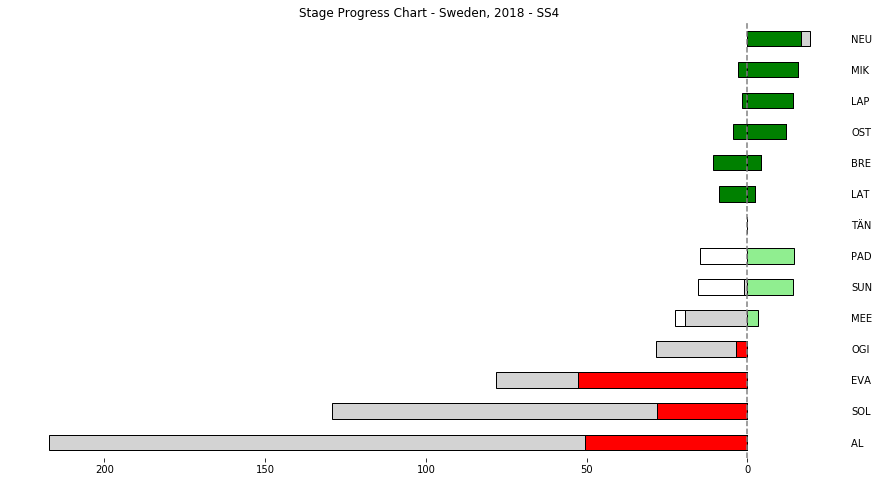

In [17]:
if __name__=='__main__':
    #rebaseStageProgressBar(stagerank,'TÄN', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')))
    #rebaseStageProgressBar(stagerank,'PAD', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')))
    #rebaseStageProgressBar(stagerank,'OST', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')))
    fig, ax = rebaseStageProgressBar(currprevstagerank,'TÄN', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')));


Solid color shows we are consolidating a position. Pastel colour shows that there has been a gain or loss on leader/laggard.

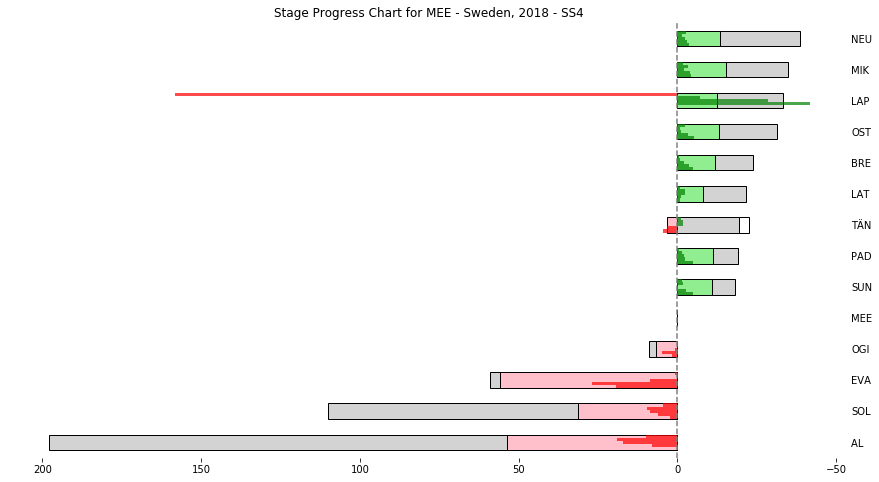

In [18]:
if __name__=='__main__':
    fig, ax = rebaseStageProgressBar(currprevstagerank,drivercode, neg='lightgreen',pos='pink',
                                     title='Stage Progress Chart for {dc} - {rally}, {year} - SS{ss}'.format(dc=drivercode,
                                                                                                             year=year,
                                                                                                             rally=rally,
                                                                                                             ss=str(snum).replace('SS','')));

    dfx = rebaseStageRankProgress(currprevstagerank, drivercode)
    dfx = dfx.sort_values('rebased_curr',ascending=False)
    order = dfx.index
    fig,ax=ssd.plotSplitSectionDelta(rebasedsplitdurations,drivercode,order,fig,ax,alpha=0.7,invert_yaxis=False);
    

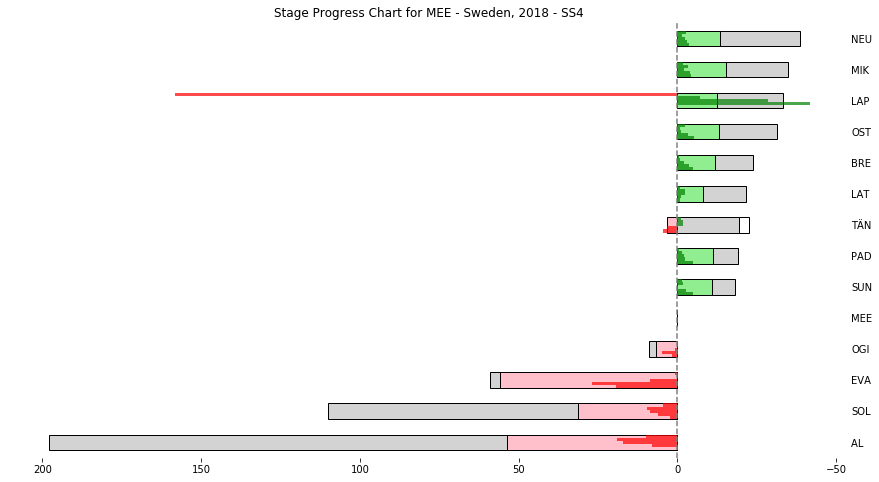

In [19]:
if __name__=='__main__':
    fig, ax = rebaseStageProgressBar(currprevstagerank,drivercode, neg='lightgreen',pos='pink',
                                     title='Stage Progress Chart for {dc} - {rally}, {year} - SS{ss}'.format(dc=drivercode,
                                                                                                             year=year,
                                                                                                             rally=rally,
                                                                                                             ss=str(snum).replace('SS','')),
                                splitdurations=splitdurations);
    fig.savefig('test1.png')   # save the figure to file

## Test Outputter

In [20]:
#!/Users/ajh59/anaconda3/bin/conda install -y unidecode
#In some cases we may want to remove unicode characters and use a simple ascii equivalent
import unidecode
if __name__=='__main__':
    unidecode.unidecode('TÄN')

In [21]:
if __name__=='__main__':
    txt=''
    !mkdir -p testout/img
    path='testout/'
    with open('{}testfile1.md'.format(path), 'w') as file:
        for dc in currprevstagerank['driver.code'].unique():
            fig, ax = rebaseStageProgressBar(currprevstagerank,dc, neg='lightgreen',pos='pink',
                                     title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,
                                                                                                    rally=rally,
                                                                                                    ss=str(snum).replace('SS','')));
            img='img/test_{}_{}.png'.format(str(snum).replace('SS',''), unidecode.unidecode(dc))
            fig.savefig('{}{}'.format(path,img))   # save the figure to file
            plt.close(fig)  
            file.write('# Stage Progress Chart - {rally}, {year} - {dc} - SS{ss}\n\n'.format(year=year,rally=rally,
                                                                                  dc=dc,
                                                                                  ss=str(snum).replace('SS','')))
            file.write('![]({})\n'.format(img))

        

Here's a test fig:

![](test1.png)